In [3]:
import numpy as np
import torch
import scipy
import csv
from PIL import Image
import glob
import os
import imageio
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import csv
import ipdb
import sys
import base64
import random
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

In [4]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.conv1 = nn.Conv2d(2,20,kernel_size=(5,5),stride=(1,1))
        nn.init.xavier_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(20)
        
        self.conv2 = nn.Conv2d(20,10,kernel_size=(5,5),stride=(1,1))
        nn.init.xavier_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(10)
        
        self.fc1 = nn.Linear(1690,500)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn3 = nn.BatchNorm1d(500)
        
        self.fc2 = nn.Linear(500,100)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.bn4 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100,1)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False)
        x = F.relu(x)
        
        
        x = self.conv2(x)
        x = F.max_pool2d(x,kernel_size=2, stride=2, padding=0,dilation=1,ceil_mode=False)
        x = F.relu(x)
        
        
        x = x.view(x.size(0),1690)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = F.dropout(x,p=0.5)
        
        x = self.fc2(x)
        x = torch.tanh(x)
        x = F.dropout(x,p=0.5)
        
        x = self.fc3(x)
        
        
        return x

In [5]:
def getdataloaders(data,batch_size=50):
    np.random.shuffle(data)
    batches=[]
    
    re = data[:,1].astype(np.float64)
    re -= re.mean(0)
    re /= re.var(0)
    re = re.reshape(re.shape[0],1)
    re = re.astype(np.str)
    
    data = np.delete(data,1,1)
    data = np.insert(data,[1],re,axis =1)
    
    train_data1=data[:15000,:]
    test_data1=data[15000:,:]

    #creating train batches
    train_batch_number = int(train_data1.shape[0]/batch_size)
    train_data = []
    
    for idx in range(0,train_batch_number):
        data = train_data1[idx*batch_size:(idx + 1)*batch_size]    
        train_data.append(data)
    
    train_data = np.array(train_data)
    
    #creating test batches
    test_batch_number = int(test_data1.shape[0]/batch_size)
    test_data = []
    
    for idx in range(0,test_batch_number):
        data = test_data1[idx*batch_size:(idx + 1)*batch_size,:]
        test_data.append(data)
        
    test_data = np.array(test_data)
    
    return train_data, test_data

In [14]:
def train(trainloader, optimizer, criterion, epoch, net, scope = 'cl'):
    
    net.train()
    train_loss_sum = 0
    for idx,batch in enumerate(trainloader):
        image_batch=[]

        if scope == 'cl':
            
            target = (trainloader[idx,:,3]).reshape((len(trainloader[idx,:,3]),1))
            target= target.astype(float)
            target = torch.from_numpy(target).float()
            
        if scope == 'cd':
            target = trainloader[idx,:,4].reshape((len(trainloader[idx,:,3]),1))
            target= target.astype(float)
            target = torch.from_numpy(target).float()
    
        for ndx,row in enumerate(batch):
            image_name= trainloader[idx,ndx,0]+'_'+ str(int(float(trainloader[idx,ndx,2])))+'.png'
            image= imageio.imread('./data_images/'+image_name)
            re_array=np.full((64,64),trainloader[idx,ndx,1])
            image=np.dstack((re_array,image))
            image_batch.append(image)
        image_batch=np.array(image_batch,dtype = float)
        image_batch=np.transpose(image_batch,(0,3,1,2))   
        
        #feeding input to the network
        image_batch = torch.from_numpy(image_batch).float()
        output = net(image_batch)
        loss = criterion(output,target)
        #print("Train loss", loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        train_loss_sum += float(loss)
        if idx % 50 == 0:
            print('epoch ', epoch, ' batch_no ', idx, ' Train loss ', loss)

    train_loss = train_loss_sum/trainloader.shape[0]
    print("epoch: ", epoch," epoch_train_loss: ", train_loss)       
    return train_loss

def test(testloader, criterion, epoch, epochs, net, scope = 'cl'):
    net.eval()
    test_loss_sum = 0    
    last_epoch=[]
    
    for idx,batch in enumerate(testloader):
        image_batch=[]
        if epoch == epochs-1:
            last_batch = batch
        
        if scope == 'cl':
            target = testloader[idx,:,3].reshape((len(testloader[idx,:,3]),1))
            target= target.astype(float)
            target = torch.from_numpy(target).float()
        if scope == 'cd':
            target = testloader[idx,:,4].reshape((len(testloader[idx,:,3]),1))
            target= target.astype(float)
            target = torch.from_numpy(target).float()
    
        for ndx,row in enumerate(batch):
            image_name = testloader[idx,ndx,0]+'_'+ str(int(float(testloader[idx,ndx,2])))+'.png'
            image = imageio.imread('./data_images/'+image_name)
            re_array = np.full((64,64),testloader[idx,ndx,1])
            image = np.dstack((re_array,image))
            image_batch.append(image.float())
            
        image_batch = np.array(image_batch,dtype = float)
        image_batch = np.transpose(image_batch,(0,3,1,2))
        image_batch = torch.from_numpy(image_batch).float()
        
        #feeding input to the network
        output = net(image_batch)
        
        loss = criterion(output,target)
        
        test_loss_sum += float(loss)
        
        if epoch == epochs-1:
            output = output.detach().numpy()
            last_batch = np.insert(last_batch,[5],output,axis =1) # adding prediction column for the batch 
            last_epoch.append(last_batch) # appending all the batches in the last epoch list

        else:
            last_epoch = 5

        if idx % 20 == 0:
            print('epoch ', epoch, ' batch_no ', idx, ' Test loss ', loss)

    test_loss = test_loss_sum/testloader.shape[0]  
    print("epoch: ", epoch, ' epoch_test_loss: ', test_loss)       
    return test_loss, last_epoch

ValueError: axes don't match array

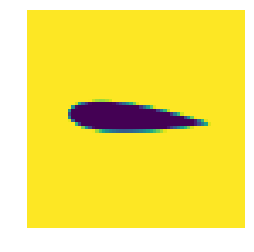

In [15]:
batch_number = 50
learning_rate = 0.0001
epochs = 1

data=np.load("data.npy")
train_data, test_data = getdataloaders(data)


#creating the network and defining loss function
cnn_foil = Net1()
optimizer = torch.optim.Adam(cnn_foil.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
epoch_list = []

#training the network
for epoch in range(epochs):
    train_loss = train(train_data, optimizer, criterion, epoch, cnn_foil, scope = 'cl')
    test_loss, output_data = test(test_data, criterion, epoch,epochs, cnn_foil, scope = 'cl')

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    epoch_list.append(epoch)

In [94]:
output_data=np.array(output_data)
np.save("Foil_CNN_prediction",output_data)
output_data=output_data.reshape((4500,6))
output_data=output_data.astype(str)
np.savetxt("Foil_CNN_prediction.csv", output_data, delimiter=",", fmt='%s')

In [95]:
np.save("train loss",train_loss_list)
np.save("test loss",test_loss_list)